In [4]:
import pandas as pd
import numpy as np
import tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

In [5]:
x_train = pd.read_csv("/kaggle/input/ahcd1/csvTrainImages 13440x1024.csv",header=None)
y_train = pd.read_csv("/kaggle/input/ahcd1/csvTrainLabel 13440x1.csv",header=None)

x_test = pd.read_csv("/kaggle/input/ahcd1/csvTestImages 3360x1024.csv",header=None)
y_test = pd.read_csv("/kaggle/input/ahcd1/csvTestLabel 3360x1.csv",header=None)

In [6]:
x_train = x_train.to_numpy().reshape(-1, 32, 32)
y_train = y_train.to_numpy().flatten() - 1
x_test = x_test.to_numpy().reshape(-1, 32, 32)
y_test = y_test.to_numpy().flatten() - 1

# Convert grayscale images to 3-channel images
x_train = np.stack((x_train,) * 3, axis=-1) / 255.0
x_test = np.stack((x_test,) * 3, axis=-1) / 255.0

# Shuffle the datasets
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

# One-hot encode the labels
y_train_h = to_categorical(y_train, num_classes=28)
y_test_h = to_categorical(y_test, num_classes=28)

# Split the training data into training and validation sets
x_train, x_val, y_train_h, y_val_h = train_test_split(x_train, y_train_h, test_size=0.2, random_state=42)

# Data augmentation for training data generator
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

# Prepare data generators
train_generator = train_datagen.flow(x_train, y_train_h, batch_size=64)
val_generator = train_datagen.flow(x_val, y_val_h, batch_size=64)
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(x_test, y_test_h, batch_size=64)

# ResNet50 model
base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))
x = GlobalAveragePooling2D()(base_model.output)
predictions = Dense(28, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

learning_rate = 0.0001

# Create an Adam optimizer with the desired learning rate
adam_optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_acc = []  # List to store accuracy

    def on_epoch_end(self, epoch, logs=None):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        self.test_acc.append(acc)  # Append accuracy to the list
        print(f'\nTesting loss: {loss}, acc: {acc}')

test_callback = TestCallback((x_test, y_test_h))

# Train the model
history = model.fit(
    train_generator, 
    epochs=100,  # Adjust the number of epochs as needed
    validation_data=val_generator,
    callbacks=[learning_rate_reduction, test_callback]
)


Epoch 1/100
168/168 [==============================] - ETA: 0s - loss: 3.8442 - accuracy: 0.0757
Testing loss: 3.528468608856201, acc: 0.0357142873108387
168/168 [==============================] - 44s 64ms/step - loss: 3.8442 - accuracy: 0.0757 - val_loss: 3.5438 - val_accuracy: 0.0346 - lr: 1.0000e-04
Epoch 2/100
167/168 [============================>.] - ETA: 0s - loss: 3.1645 - accuracy: 0.1383
Testing loss: 3.857316017150879, acc: 0.0446428582072258
168/168 [==============================] - 9s 56ms/step - loss: 3.1633 - accuracy: 0.1379 - val_loss: 3.9072 - val_accuracy: 0.0439 - lr: 1.0000e-04
Epoch 3/100
168/168 [==============================] - ETA: 0s - loss: 2.7239 - accuracy: 0.1950
Testing loss: 3.3336496353149414, acc: 0.12113095074892044
168/168 [==============================] - 9s 56ms/step - loss: 2.7239 - accuracy: 0.1950 - val_loss: 3.7679 - val_accuracy: 0.0848 - lr: 1.0000e-04
Epoch 4/100
167/168 [============================>.] - ETA: 0s - loss: 2.3768 - accuracy

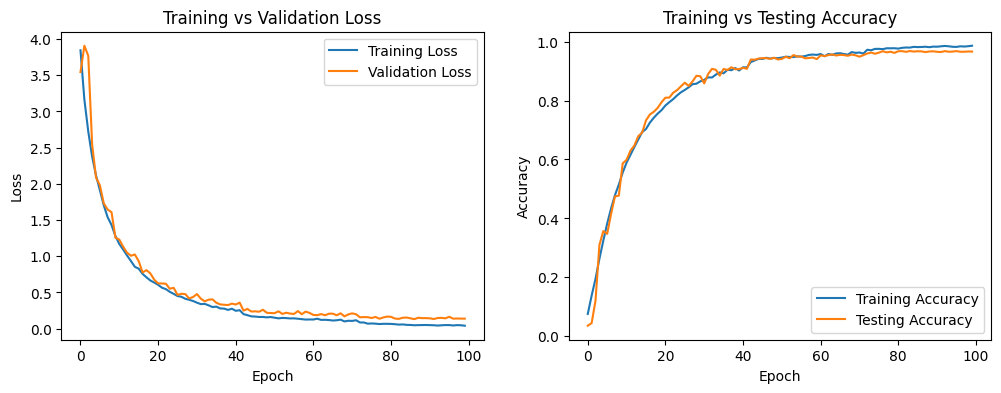

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(test_callback.test_acc, label='Testing Accuracy')
plt.title('Training vs Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# Load and preprocess the data
x_train = pd.read_csv("/kaggle/input/ahcd1/csvTrainImages 13440x1024.csv", header=None)
y_train = pd.read_csv("/kaggle/input/ahcd1/csvTrainLabel 13440x1.csv", header=None)
x_test = pd.read_csv("/kaggle/input/ahcd1/csvTestImages 3360x1024.csv", header=None)
y_test = pd.read_csv("/kaggle/input/ahcd1/csvTestLabel 3360x1.csv", header=None)

x_train = x_train.to_numpy().reshape(-1, 32, 32)
y_train = y_train.to_numpy().flatten() - 1
x_test = x_test.to_numpy().reshape(-1, 32, 32)
y_test = y_test.to_numpy().flatten() - 1

x_train = np.stack((x_train,) * 3, axis=-1) / 255.0
x_test = np.stack((x_test,) * 3, axis=-1) / 255.0

x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

y_train_h = to_categorical(y_train, num_classes=28)
y_test_h = to_categorical(y_test, num_classes=28)

x_train, x_val, y_train_h, y_val_h = train_test_split(x_train, y_train_h, test_size=0.2, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(x_train, y_train_h, batch_size=64)
val_generator = train_datagen.flow(x_val, y_val_h, batch_size=64)
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(x_test, y_test_h, batch_size=64)

# Building the model
base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(28, activation='softmax')  # Assuming 28 classes
])

# Compile the model
learning_rate = 0.0001
adam_optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_acc = []

    def on_epoch_end(self, epoch, logs=None):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        self.test_acc.append(acc)
        print(f'\nTesting loss: {loss}, acc: {acc}')

test_callback = TestCallback((x_test, y_test_h))

# Train the model
history = model.fit(
    train_generator, 
    epochs=100,  # Adjust the number of epochs as needed
    validation_data=val_generator,
    callbacks=[learning_rate_reduction, test_callback]
)

Epoch 1/100
168/168 [==============================] - ETA: 0s - loss: 3.2490 - accuracy: 0.0751
Testing loss: 3.5349795818328857, acc: 0.0357142873108387
168/168 [==============================] - 45s 65ms/step - loss: 3.2490 - accuracy: 0.0751 - val_loss: 3.5376 - val_accuracy: 0.0312 - lr: 1.0000e-04
Epoch 2/100
167/168 [============================>.] - ETA: 0s - loss: 2.8670 - accuracy: 0.1501
Testing loss: 3.8211276531219482, acc: 0.03898809477686882
168/168 [==============================] - 10s 60ms/step - loss: 2.8660 - accuracy: 0.1499 - val_loss: 3.8721 - val_accuracy: 0.0379 - lr: 1.0000e-04
Epoch 3/100
167/168 [============================>.] - ETA: 0s - loss: 2.5024 - accuracy: 0.2109
Testing loss: 3.8447628021240234, acc: 0.09047619253396988
168/168 [==============================] - 10s 59ms/step - loss: 2.5007 - accuracy: 0.2112 - val_loss: 4.3310 - val_accuracy: 0.0707 - lr: 1.0000e-04
Epoch 4/100
167/168 [============================>.] - ETA: 0s - loss: 2.1913 - acc

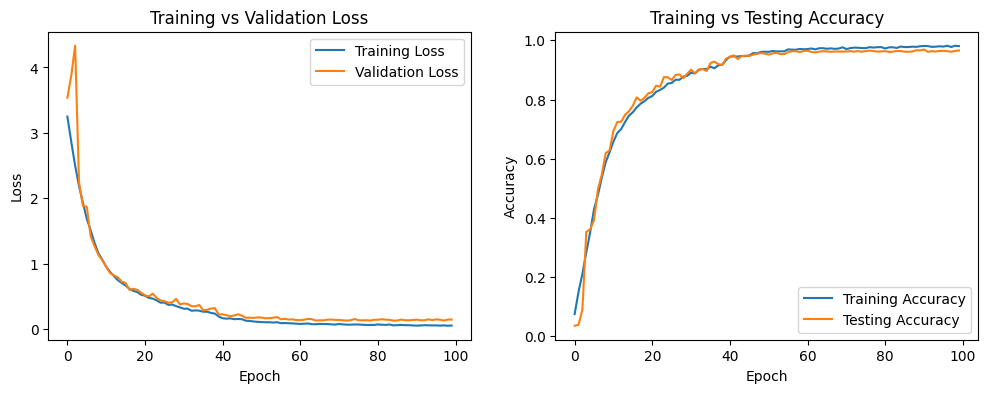

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(test_callback.test_acc, label='Testing Accuracy')
plt.title('Training vs Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()